# Backtest

This section will cover following topics:

- How to create a TimeSeriesSplitter
- How to create a BackTester and retrieve the backtesting results
- How to leverage the backtesting to tune the hyper-parameters for orbit models

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.models import LGT, DLT
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.diagnostics.plot import plot_bt_predictions
from orbit.diagnostics.metrics import smape, wmape
from orbit.utils.dataset import load_iclaims


import warnings
warnings.filterwarnings('ignore')

In [2]:
print(orbit.__version__)

1.1.3dev


In [3]:
# load log-transformed data
data = load_iclaims()

In [4]:
data.shape

(443, 7)

The way to gauge the performance of a time-series model is through re-training models with different historic periods and check their forecast within certain steps. This is similar to a time-based style cross-validation. More often, it is called `backtest` in time-series modeling.

The purpose of this notebook is to illustrate how to `backtest` a single model using `BackTester`

`BackTester` will compose a `TimeSeriesSplitter` within it, but `TimeSeriesSplitter` is useful as a standalone, in case there are other tasks to perform that requires splitting but not backtesting. `TimeSeriesSplitter` implemented each 'slices' as generator, i.e it can be used in a for loop. You can also retrieve the composed `TimeSeriesSplitter` object from `BackTester` to utilize the additional methods in `TimeSeriesSplitter`

Currently, there are two schemes supported for the back-testing engine: expanding window and rolling window.

* **expanding window**: for each back-testing model training, the train start date is fixed, while the train end date is extended forward.
* **rolling window**: for each back-testing model training, the training window length is fixed but the window is moving forward.

## Create a TimeSeriesSplitter

There two main way to splitting a time series: expanding and rolling. Expanding window has a fixed starting point, and the window length grows as users move forward in time series. It is useful when users want to incorporate all historical information. On the other hand, rolling window has a fixed window length, and the starting point of the window moves forward as users move forward in time series. Below section illustrates how users can use `TimeSeriesSplitter` to split the claims time series.

###  Expanding window

In [5]:
# configs
min_train_len = 380 # minimal length of window length
forecast_len = 20 # length forecast window
incremental_len = 20 # step length for moving forward

In [6]:
ex_splitter = TimeSeriesSplitter(df=data,
                                 min_train_len=min_train_len,
                                 incremental_len=incremental_len,
                                 forecast_len=forecast_len, 
                                 window_type='expanding',
                                 date_col='week')

In [7]:
print(ex_splitter)


------------ Fold: (1 / 3)------------
Train start date: 2010-01-03 00:00:00 Train end date: 2017-04-09 00:00:00
Test start date: 2017-04-16 00:00:00 Test end date: 2017-08-27 00:00:00

------------ Fold: (2 / 3)------------
Train start date: 2010-01-03 00:00:00 Train end date: 2017-08-27 00:00:00
Test start date: 2017-09-03 00:00:00 Test end date: 2018-01-14 00:00:00

------------ Fold: (3 / 3)------------
Train start date: 2010-01-03 00:00:00 Train end date: 2018-01-14 00:00:00
Test start date: 2018-01-21 00:00:00 Test end date: 2018-06-03 00:00:00



Users can visualize the splits using the internal `plot()` function. One may notice that the last few data points may not be included in the last split, which is expected when `min_train_len` is specified.

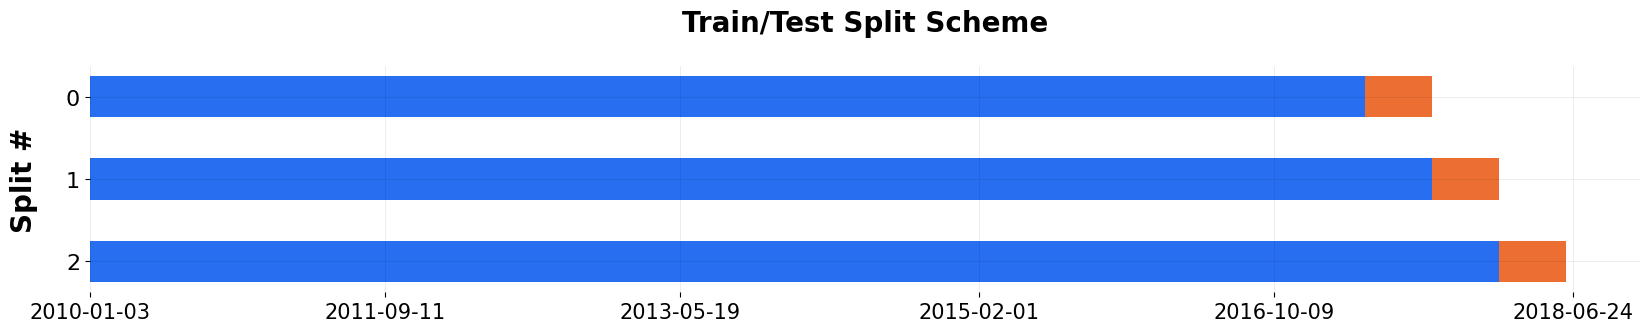

In [8]:
_ = ex_splitter.plot()

If users want to visualize the scheme in terms of indcies, one can do the following.

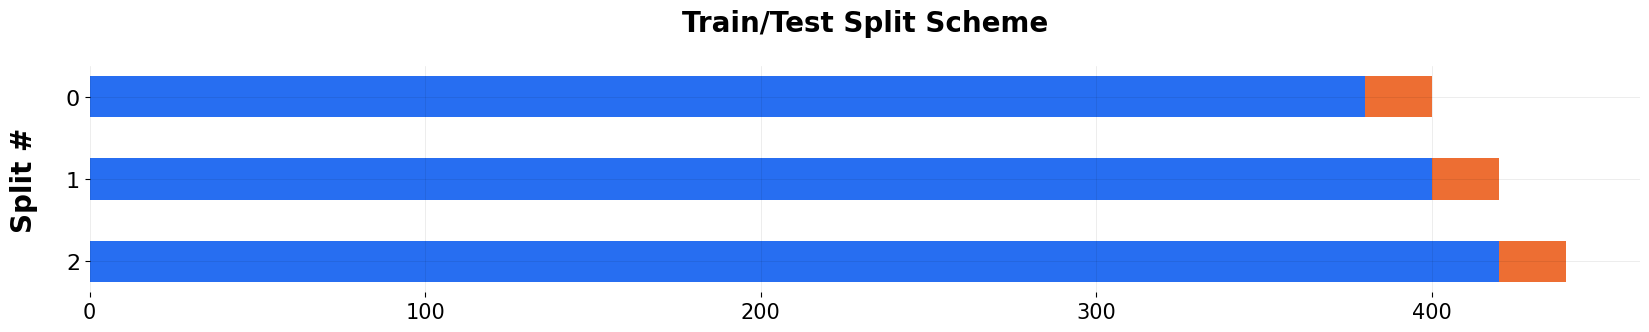

In [9]:
_ = ex_splitter.plot(show_index=True)

### Rolling window

In [10]:
# configs
min_train_len = 380 # in case of rolling window, this specify the length of window length
forecast_len = 20 # length forecast window
incremental_len = 20 # step length for moving forward

In [11]:
roll_splitter = TimeSeriesSplitter(data, 
                                   min_train_len=min_train_len, 
                                   incremental_len=incremental_len, 
                                   forecast_len=forecast_len, 
                                   window_type='rolling', date_col='week')

Users can visualize the splits, green is training window and yellow it the forecasting window. The window length is always 380, while the starting point moves forward 20 weeks each steps. 

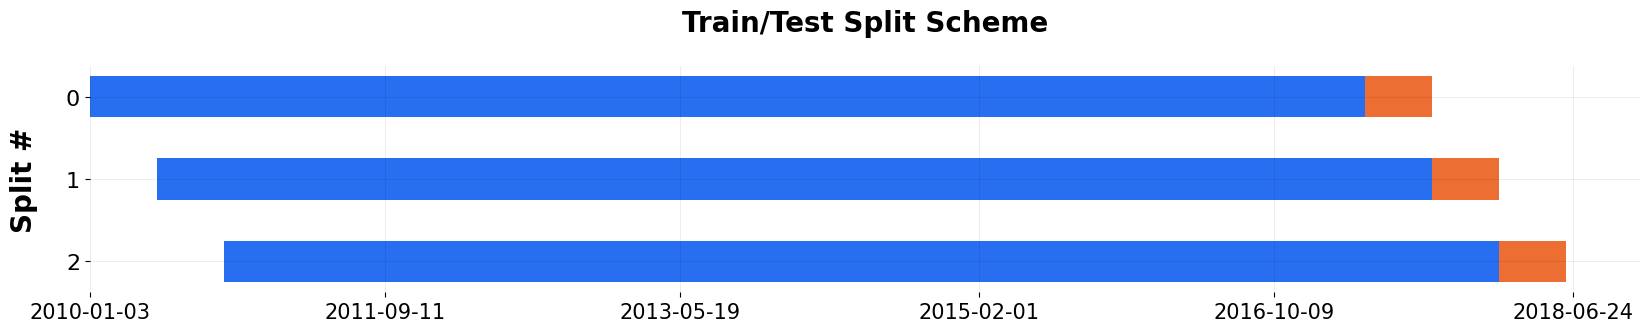

In [12]:
_ = roll_splitter.plot()

### Specifying number of splits

User can also define number of splits using `n_splits` instead of specifying minimum training length.  That way, minimum training length will be automatically calculated.

In [13]:
ex_splitter2 = TimeSeriesSplitter(data, 
                                  min_train_len=min_train_len, 
                                  incremental_len=incremental_len, 
                                  forecast_len=forecast_len, 
                                  n_splits=5, 
                                  window_type='expanding', date_col='week')

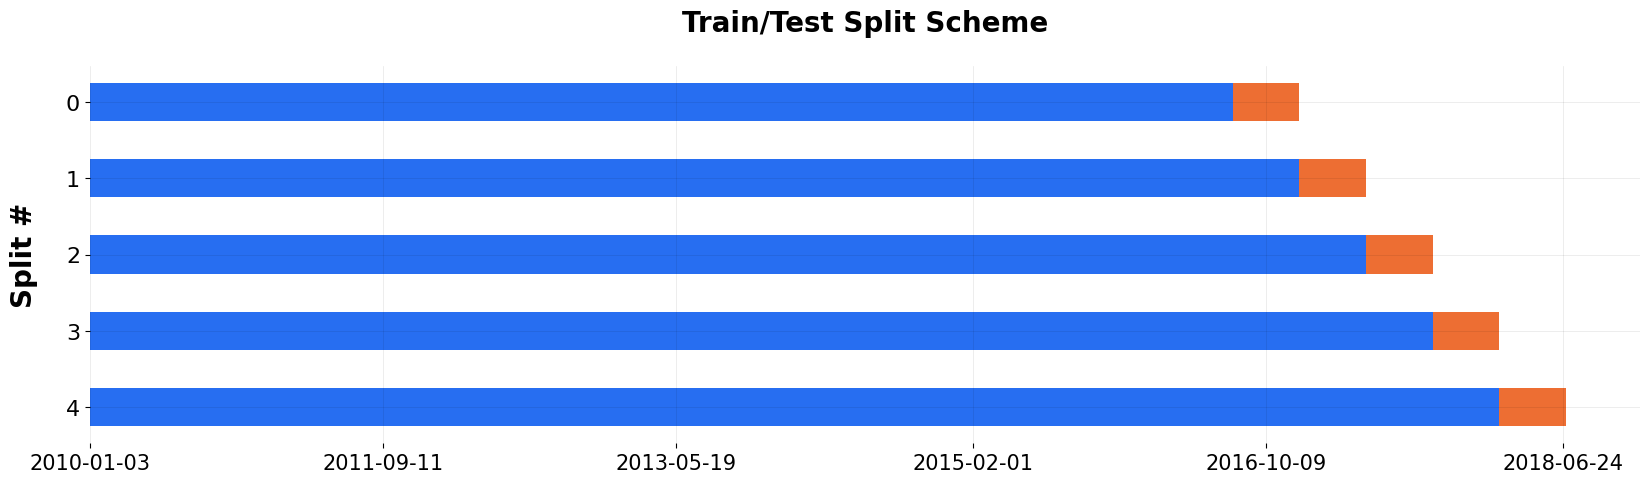

In [14]:
_ = ex_splitter2.plot()

### TimeSeriesSplitter as generator

`TimeSeriesSplitter` is implemented as a generator, therefore users can call `split()` to loop through it. It comes handy even for tasks other than backtest. 

In [15]:
 for train_df, test_df, scheme, key in roll_splitter.split():
        print('Initial Claim slice {} rolling mean:{:.3f}'.format(key, train_df['claims'].mean()))

Initial Claim slice 0 rolling mean:12.712
Initial Claim slice 1 rolling mean:12.671
Initial Claim slice 2 rolling mean:12.647


## Create a BackTester

To actually run backtest, first let's initialize a `DLT` model and a `BackTester`. You pass in `TimeSeriesSplitter` parameters to `BackTester`. 

In [16]:
# instantiate a model
dlt = DLT(
    date_col='week',
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=52,
    estimator='stan-map',
    # reduce number of messages
    verbose=False,
)

In [17]:
# configs
min_train_len = 100 
forecast_len = 20 
incremental_len = 100 
window_type = 'expanding'

bt = BackTester(
    model=dlt,
    df=data,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

## Backtest fit and predict

The most expensive portion of backtesting is fitting the model iteratively. Thus, users can separate the API calls for `fit_predict` and `score` to avoid redundant computation for multiple metrics or scoring methods

In [18]:
bt.fit_predict()

Once `fit_predict()` is called, the fitted models and predictions can be easily retrieved from `BackTester`. Here the data is grouped by the date, split_key, and whether or not that observation is part of the training or test data

In [19]:
predicted_df = bt.get_predicted_df()
predicted_df.head()

,date,actual,prediction,training_data,split_key
0,2010-01-03,13.386595,13.386595,True,0
1,2010-01-10,13.624218,13.649077,True,0
2,2010-01-17,13.398741,13.373116,True,0
3,2010-01-24,13.137549,13.151829,True,0
4,2010-01-31,13.196760,13.187769,True,0


A plotting utility is also provided to visualize the predictions against the actuals for each split.

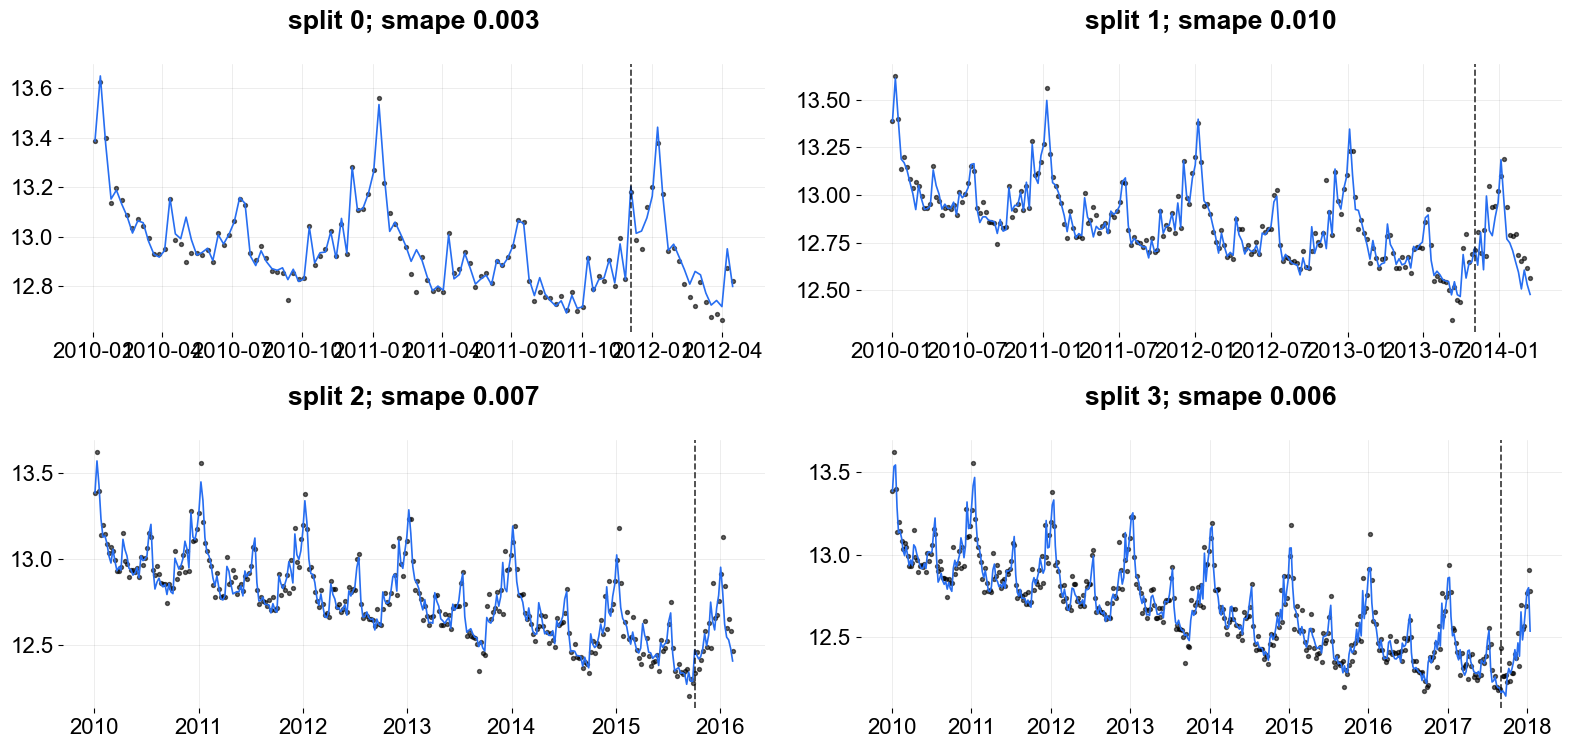

In [20]:
plot_bt_predictions(predicted_df, metrics=smape, ncol=2, include_vline=True);

Users might find this useful for any custom computations that may need to be performed on the set of predicted data. Note that the columns are renamed to generic and consistent names.

Sometimes, it might be useful to match the data back to the original dataset for ad-hoc diagnostics. This can easily be done by merging back to the original dataset

In [21]:
predicted_df.merge(data, left_on='date', right_on='week')

,date,actual,prediction,training_data,split_key,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,13.386595,True,0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-03,13.386595,13.386595,True,1,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
2,2010-01-03,13.386595,13.386595,True,2,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
3,2010-01-03,13.386595,13.386595,True,3,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
4,2010-01-10,13.624218,13.649077,True,0,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2017-12-17,12.568616,12.566367,False,3,2017-12-17,12.568616,0.298663,0.248654,-0.216869,0.434042,-0.482380
1076,2017-12-24,12.691451,12.675776,False,3,2017-12-24,12.691451,0.328516,0.233616,-0.358839,0.430410,-0.373389
1077,2017-12-31,12.769532,12.783304,False,3,2017-12-31,12.769532,0.503457,0.069313,-0.092571,0.456087,-0.553539
1078,2018-01-07,12.908227,12.800204,False,3,2018-01-07,12.908227,0.527849,0.051295,0.029532,0.471673,-0.456456


## Backtest Scoring

The main purpose of `BackTester` are the evaluation metrics. Some of the most widely used metrics are implemented and built into the `BackTester` API.

The default metric list is **smape, wmape, mape, mse, mae, rmsse**.

In [22]:
bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.006647,False
1,wmape,0.006643,False
2,mape,0.006629,False
3,mse,0.012887,False
4,mae,0.084389,False
5,rmsse,0.810269,False


It is possible to filter for only specific metrics of interest, or even implement your own callable and pass into the `score()` method. For example, see this function that uses last observed value as a predictor and computes the `mse`. Or `naive_error` which computes the error as the delta between predicted values and the training period mean. 

Note these are not really useful error metrics, just showing some examples of callables you can use ;)

In [23]:
def mse_naive(test_actual):
    actual = test_actual[1:]
    prediction = test_actual[:-1]
    return np.mean(np.square(actual - prediction))

def naive_error(train_actual, test_prediction):
    train_mean = np.mean(train_actual)
    return np.mean(np.abs(test_prediction - train_mean))

In [24]:
bt.score(metrics=[mse_naive, naive_error])

,metric_name,metric_values,is_training_metric
0,mse_naive,0.019628,False
1,naive_error,0.229576,False


It doesn't take additional time to refit and predict the model, since the results are stored when `fit_predict()` is called. Check docstrings for function criteria that is required for it to be supported with this api.

In some cases, users may want to evaluate our metrics on both train and test data. To do this you can call score again with the following indicator

In [25]:
bt.score(include_training_metrics=True)

,metric_name,metric_values,is_training_metric
0,smape,0.006647,False
1,wmape,0.006643,False
2,mape,0.006629,False
3,mse,0.012887,False
4,mae,0.084389,False
5,rmsse,0.810269,False
6,smape,0.002738,True
7,wmape,0.002742,True
8,mape,0.002738,True
9,mse,0.003119,True


## Backtest Get Models

In cases where `BackTester` doesn't cut it or for more custom use-cases, there's an interface to export the `TimeSeriesSplitter` and predicted data, as shown earlier. It's also possible to get each of the fitted models for deeper diving

In [26]:
fitted_models = bt.get_fitted_models()

In [27]:
model_1 = fitted_models[0]
model_1.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Regular,-0.048348
1,trend.filling,Regular,-0.119761
2,trend.job,Regular,0.027741


BackTester composes a TimeSeriesSplitter within it, but TimeSeriesSplitter can also be created on its own as a standalone object. See section below on TimeSeriesSplitter for more details on how to use the splitter.

All of the additional TimeSeriesSplitter args can also be passed into BackTester on instantiation

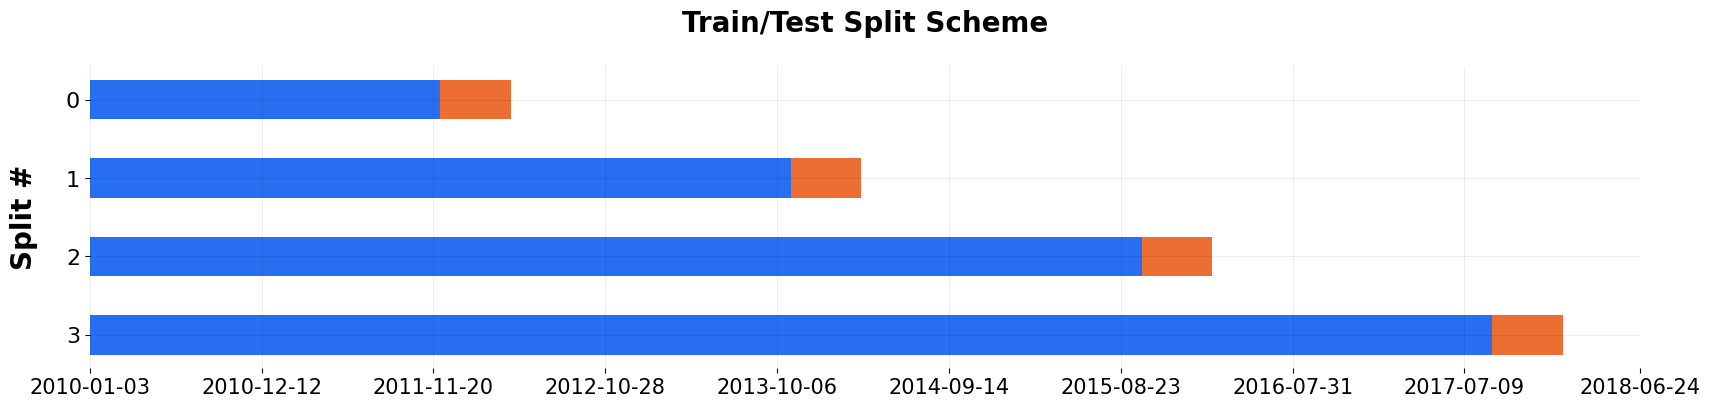

In [28]:
ts_splitter = bt.get_splitter()
_ = ts_splitter.plot()

## Hyperparameter Tunning
After seeing the results from the backtest, users may wish to fine tune the hyperparameters. Orbit also provide a `grid_search_orbit` utilities for parameter searching. It uses `Backtester` under the hood so users can compare backtest metrics for different parameters combination.

<div class="alert alert-info">

To have a consistent outlook here, users need to make sure an updated version of `ipywidgets` is installed.

</div>

In [29]:
from orbit.utils.params_tuning import grid_search_orbit

In [30]:
# defining the search space for level smoothing paramter and seasonality smooth paramter
param_grid = {
    'level_sm_input': [0.3, 0.5, 0.8],  
    'seasonality_sm_input': [0.3, 0.5, 0.8],
}

In [31]:
# configs
min_train_len = 380 # in case of rolling window, this specify the length of window length
forecast_len = 20 # length forecast window
incremental_len = 20 # step length for moving forward
best_params, tuned_df = grid_search_orbit(
    param_grid,                                    
    model=dlt,                                 
    df=data,                                
    min_train_len=min_train_len,                              
    incremental_len=incremental_len,                                 
    forecast_len=forecast_len,               
    metrics=None, 
    criteria="min", 
    verbose=False,
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [32]:
tuned_df.head() # backtest output for each parameter searched

,level_sm_input,seasonality_sm_input,metrics
0,0.3,0.3,0.004909
1,0.3,0.5,0.004057
2,0.3,0.8,0.003609
3,0.5,0.3,0.007907
4,0.5,0.5,0.006306


In [33]:
best_params # output best parameters

[{'level_sm_input': 0.3, 'seasonality_sm_input': 0.8}]